### 1. Import Packages

In [11]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la normalizzazione dei dati
from sklearn.discriminant_analysis import StandardScaler

# Librerie per la Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per il Machine Learning
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la PCA
from sklearn.decomposition import PCA

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [12]:
df = pd.read_csv('../../../data/ST001937.csv')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Sample ID", "RAW_FILE_NAME"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,Pheotypes,"1,3,5(10)-estratrien-3,6- beta-17-beta-triol","1,5-anhydroglucitol",17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-1,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-2,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-3,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-4,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-5,17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-6,1-hexadecanol,...,tyrosine-1,tyrosine-2,urea-1,urea-2,urea-3,urea-4,uridine,valine,xanthine,xanthosine
0,Benign SPNS,0.437408,0.663764,0.700609,0.096924,0.173891,0.799124,0.573520,1.105910,0.677833,...,0.689488,0.037373,0.595031,0.234936,0.589201,0.127788,0.113960,0.216687,0.770860,0.174060
1,Benign SPNS,5.064922,0.653161,0.883121,0.056551,0.932342,0.394648,0.772451,0.623514,0.769287,...,0.537845,0.016517,0.484474,0.564398,0.482784,0.119055,0.009865,0.164879,0.456740,0.320723
2,Benign SPNS,1.046057,0.798040,0.838630,0.283674,0.119269,0.032103,0.807268,0.339667,1.104029,...,0.679699,1.079720,0.901623,0.559234,0.866856,0.159342,0.026922,0.252849,0.473077,0.158255
3,Benign SPNS,2.530700,1.318840,1.074717,0.431186,1.773602,0.627714,2.042268,0.913226,0.741269,...,0.837193,0.522064,1.433745,1.442062,1.406062,0.231101,0.278952,0.301997,0.940990,1.095022
4,Benign SPNS,0.027033,1.031146,0.863596,0.201422,0.222126,0.928862,1.004769,0.403102,0.790744,...,0.826921,0.462153,1.040359,1.154850,1.034635,0.198105,0.868354,0.302138,1.208439,0.557425


### 2.1 Data Cleaning

Notiamo che il dataset non presenta alcun nullo, di conseguenza non dobbiamo effettuare nessuna operazione di imputazione. Dobbiamo soltanto modificare i valori testuali della feature Pheotypes in valori numerici.

In [13]:
# Visualizziamo le colonne con dati mancanti
print(df.isnull().sum())
print("----------------------------------------------------")
print(df.isnull().sum().sum())

df['Pheotypes'] = df['Pheotypes'].apply(lambda x: 0 if x == 'Healthy Controls' else 1 if x == 'Benign SPNS' else 2)

Pheotypes                                        0
1,3,5(10)-estratrien-3,6- beta-17-beta-triol     0
1,5-anhydroglucitol                              0
17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-1    0
17-alpha-20-alpha-dihydroxy-4-pregnen-3-one-2    0
                                                ..
urea-4                                           0
uridine                                          0
valine                                           0
xanthine                                         0
xanthosine                                       0
Length: 546, dtype: int64
----------------------------------------------------
0


### 3. Extract X & Y

In [17]:
X = df.drop(columns=['Pheotypes'])
X_features_names = X.columns
y = df.Pheotypes

### 3.1 Data Scaling

### 3.2 Train-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [20]:
# Definiamo il modello XGBoost con gli iperparametri di default
model = xgb.XGBClassifier()

# Addestriamo il modello
model.fit(X_train, y_train)

# Eseguiamo le previsioni sui dati di test
y_pred = model.predict(X_test)

### 5. Initial Model Evalutation

In [21]:
# Valutiamo l'accuratezza del modello con gli iperparametri di default
accuracy = metrics.accuracy_score(y_test, y_pred)

# Visualizziamo le metriche
print(f'Accuratezza: {accuracy}')

Accuratezza: 0.853448275862069


Le prestazioni iniziali sono ottime: abbiamo un'accuratezza del 86%. Proviamo con la K-Fold Cross Validation.

In [22]:
# Testiamo diverse configurazioni di K
max = 0
k_best = 0
for k in range(5, 11): 
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    model = xgb.XGBClassifier()
    scores = cross_val_score(model, X, y, cv=kfolds)
    mean = np.mean(scores)
    if mean > max: 
        max = mean
        k_best = k
    print(f"K={k}, Accuratezza Media: {mean}")
    
print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza media massima: {max}")

K=5, Accuratezza Media: 0.8543103448275863
K=6, Accuratezza Media: 0.85946708687214
K=7, Accuratezza Media: 0.8534866739686018
K=8, Accuratezza Media: 0.8517241379310345
K=9, Accuratezza Media: 0.8534802971576227
K=10, Accuratezza Media: 0.8551724137931034
-------------------------------------------
K ottimale: 6
Accuratezza media massima: 0.85946708687214


Abbiamo ottenuto le prestazioni migliori con un numero di fold pari a 6.

In [24]:
# Creiamo l'oggetto K-Fold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

In [75]:
# Creiamo un nuovo modello XGBClassifier
model_2 = xgb.XGBClassifier()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'colsample_bylevel': [0.8, 0.9],
}

# Creiamo l'oggetto GridSearchCV
grid_search_model = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
grid_search_model.fit(X, y)

# Visualizziamo i risultati
best_params = grid_search_model.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}


In [80]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = xgb.XGBClassifier(**best_params)

In [81]:
# Addestriamo il modello con gli iperparametri ottimizzati
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Valutiamo l'accuratezza del modello con gli iperparametri ottimizzati
accuracy = metrics.accuracy_score(y_test, y_pred)

# Visualizziamo l'accuratezza
print(f'Accuratezza: {accuracy}')

Accuratezza: 0.8577586206896551


Valutiamo le prestazioni con la K-Fold Cross Validation.

In [82]:
# K-Fold Cross Validation
scores = cross_val_score(best_model, X, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.866371098409985


### 7. Feature Selection

In [85]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X, y).get_support(indices=True)
    X_top = X.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

ValueError: Input X must be non-negative.

In [ ]:
X_top = X[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.81875


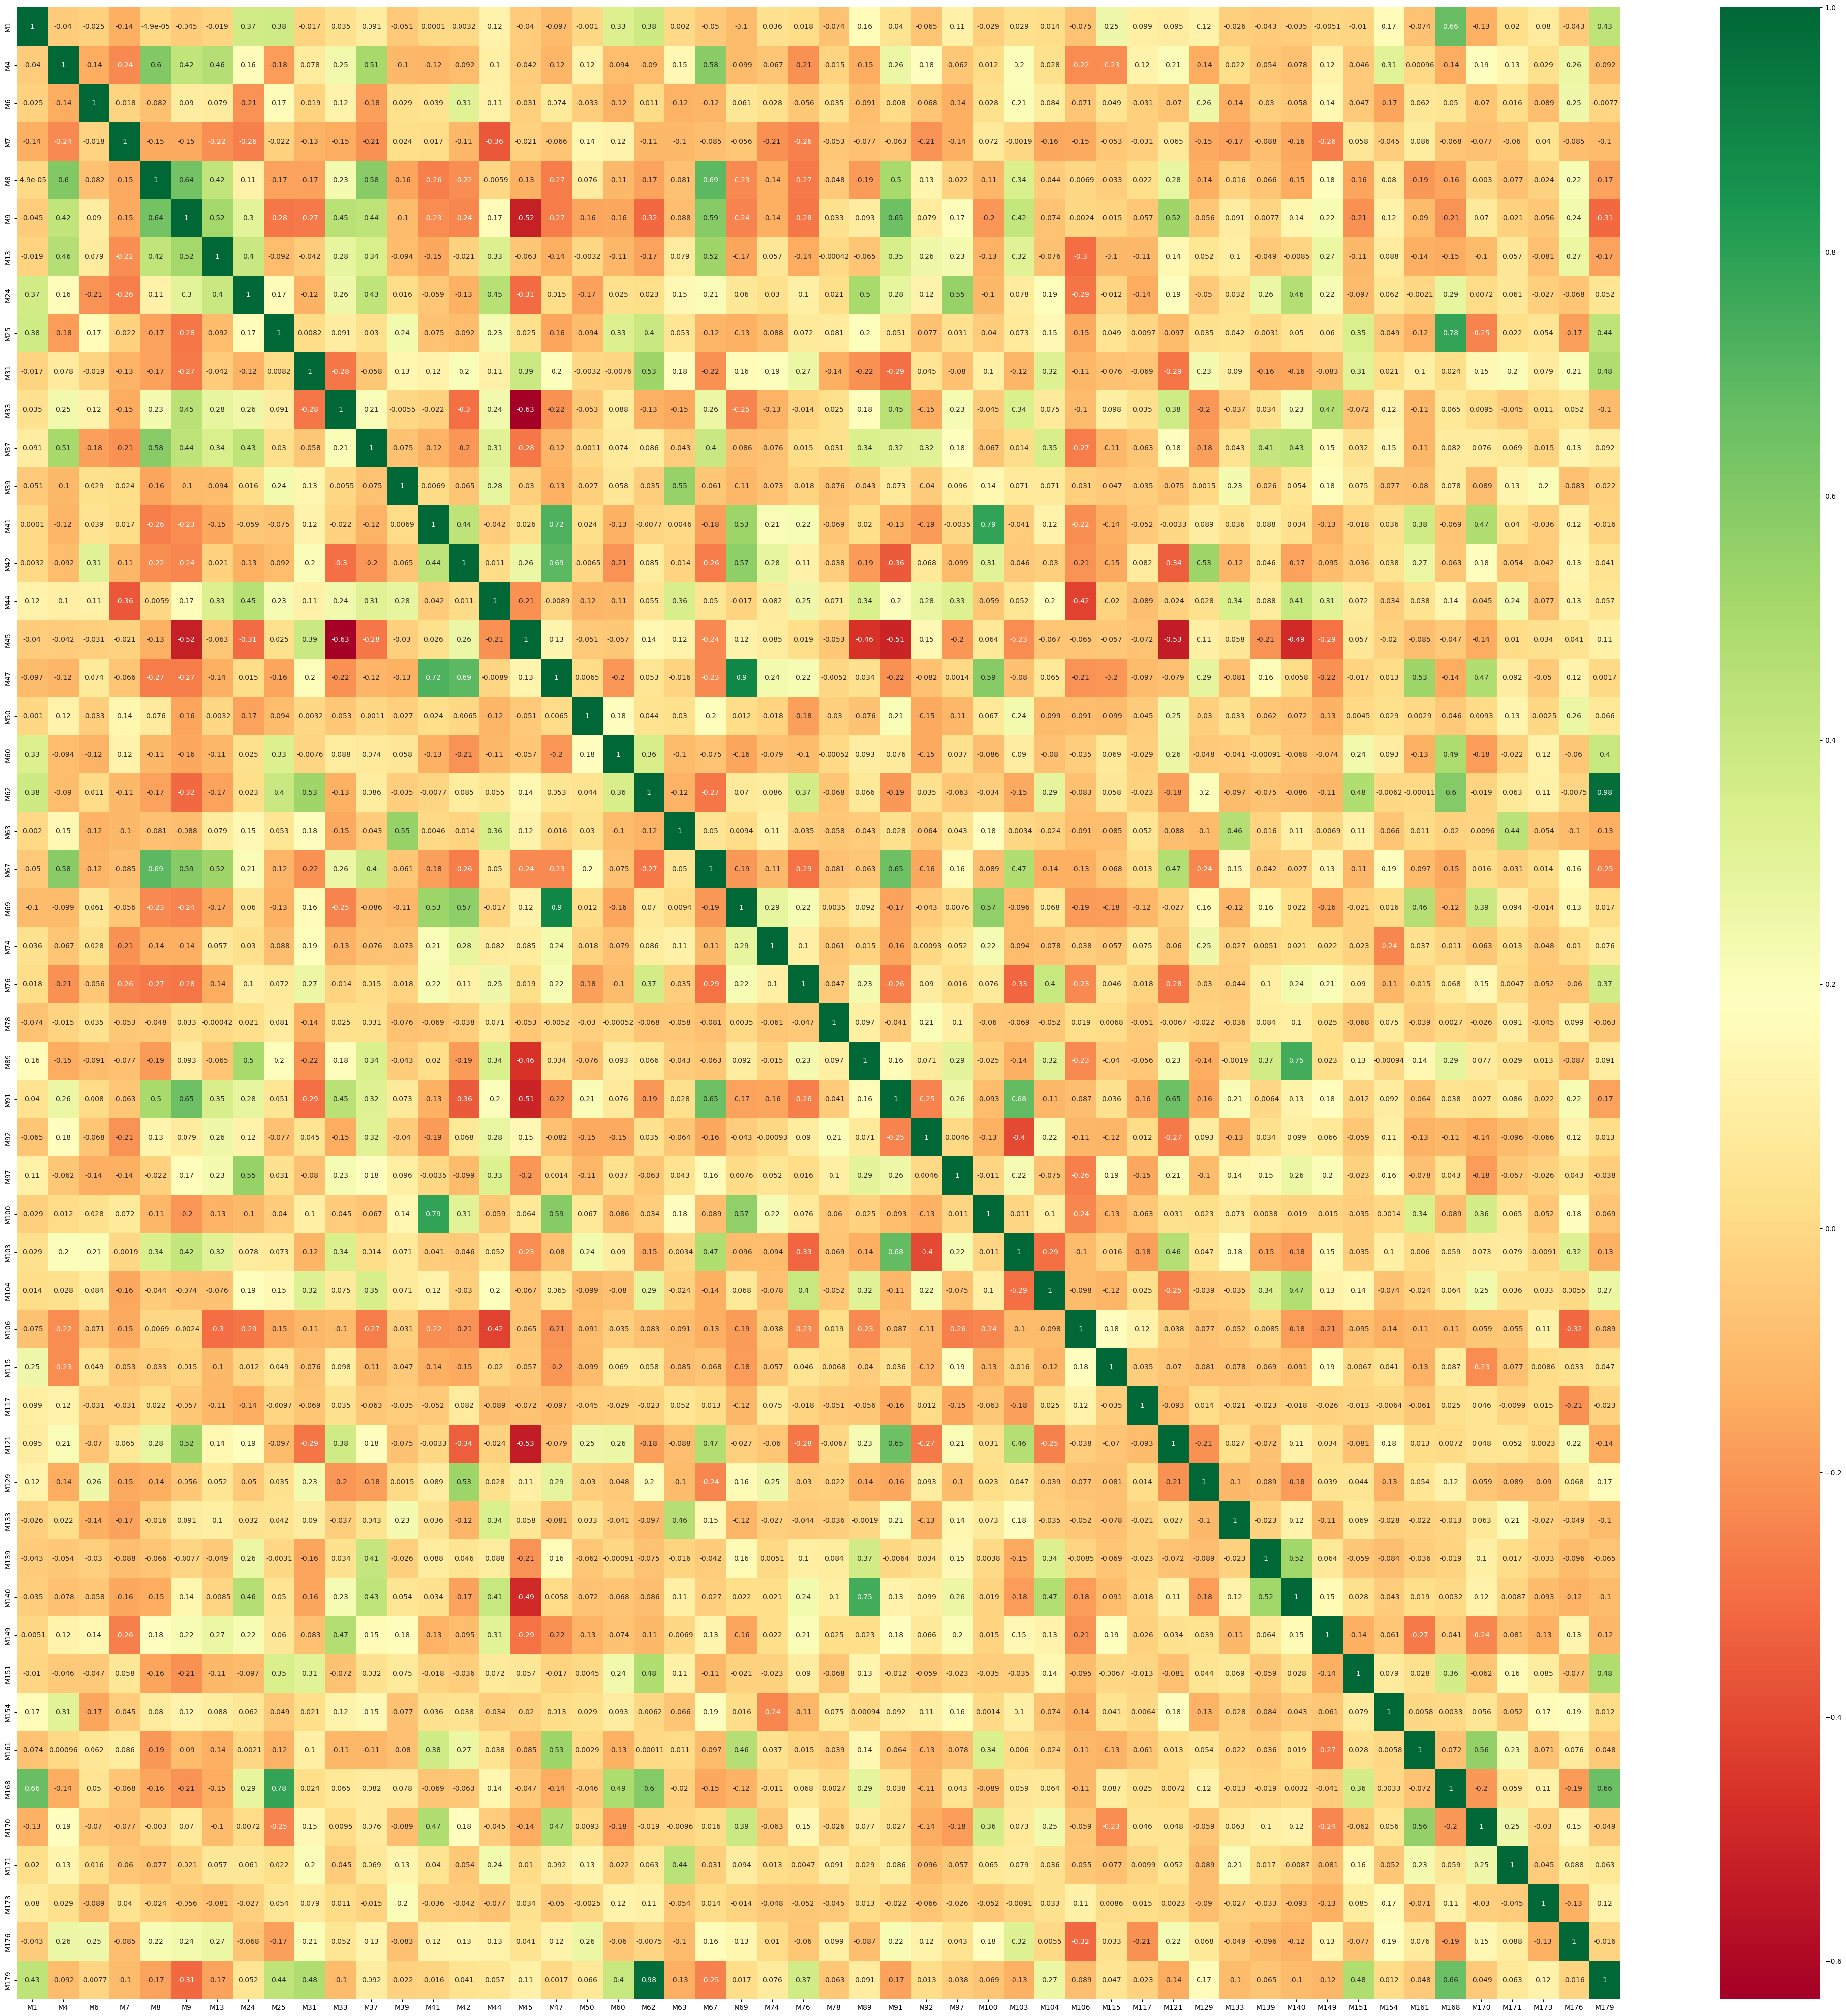

In [ ]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 8. PCA

In [ ]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
print("Numero di componenti principali:", d)

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X)

Numero di componenti principali: 3


In [ ]:
scores = cross_val_score(best_model, X_reduced, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.5643382352941176


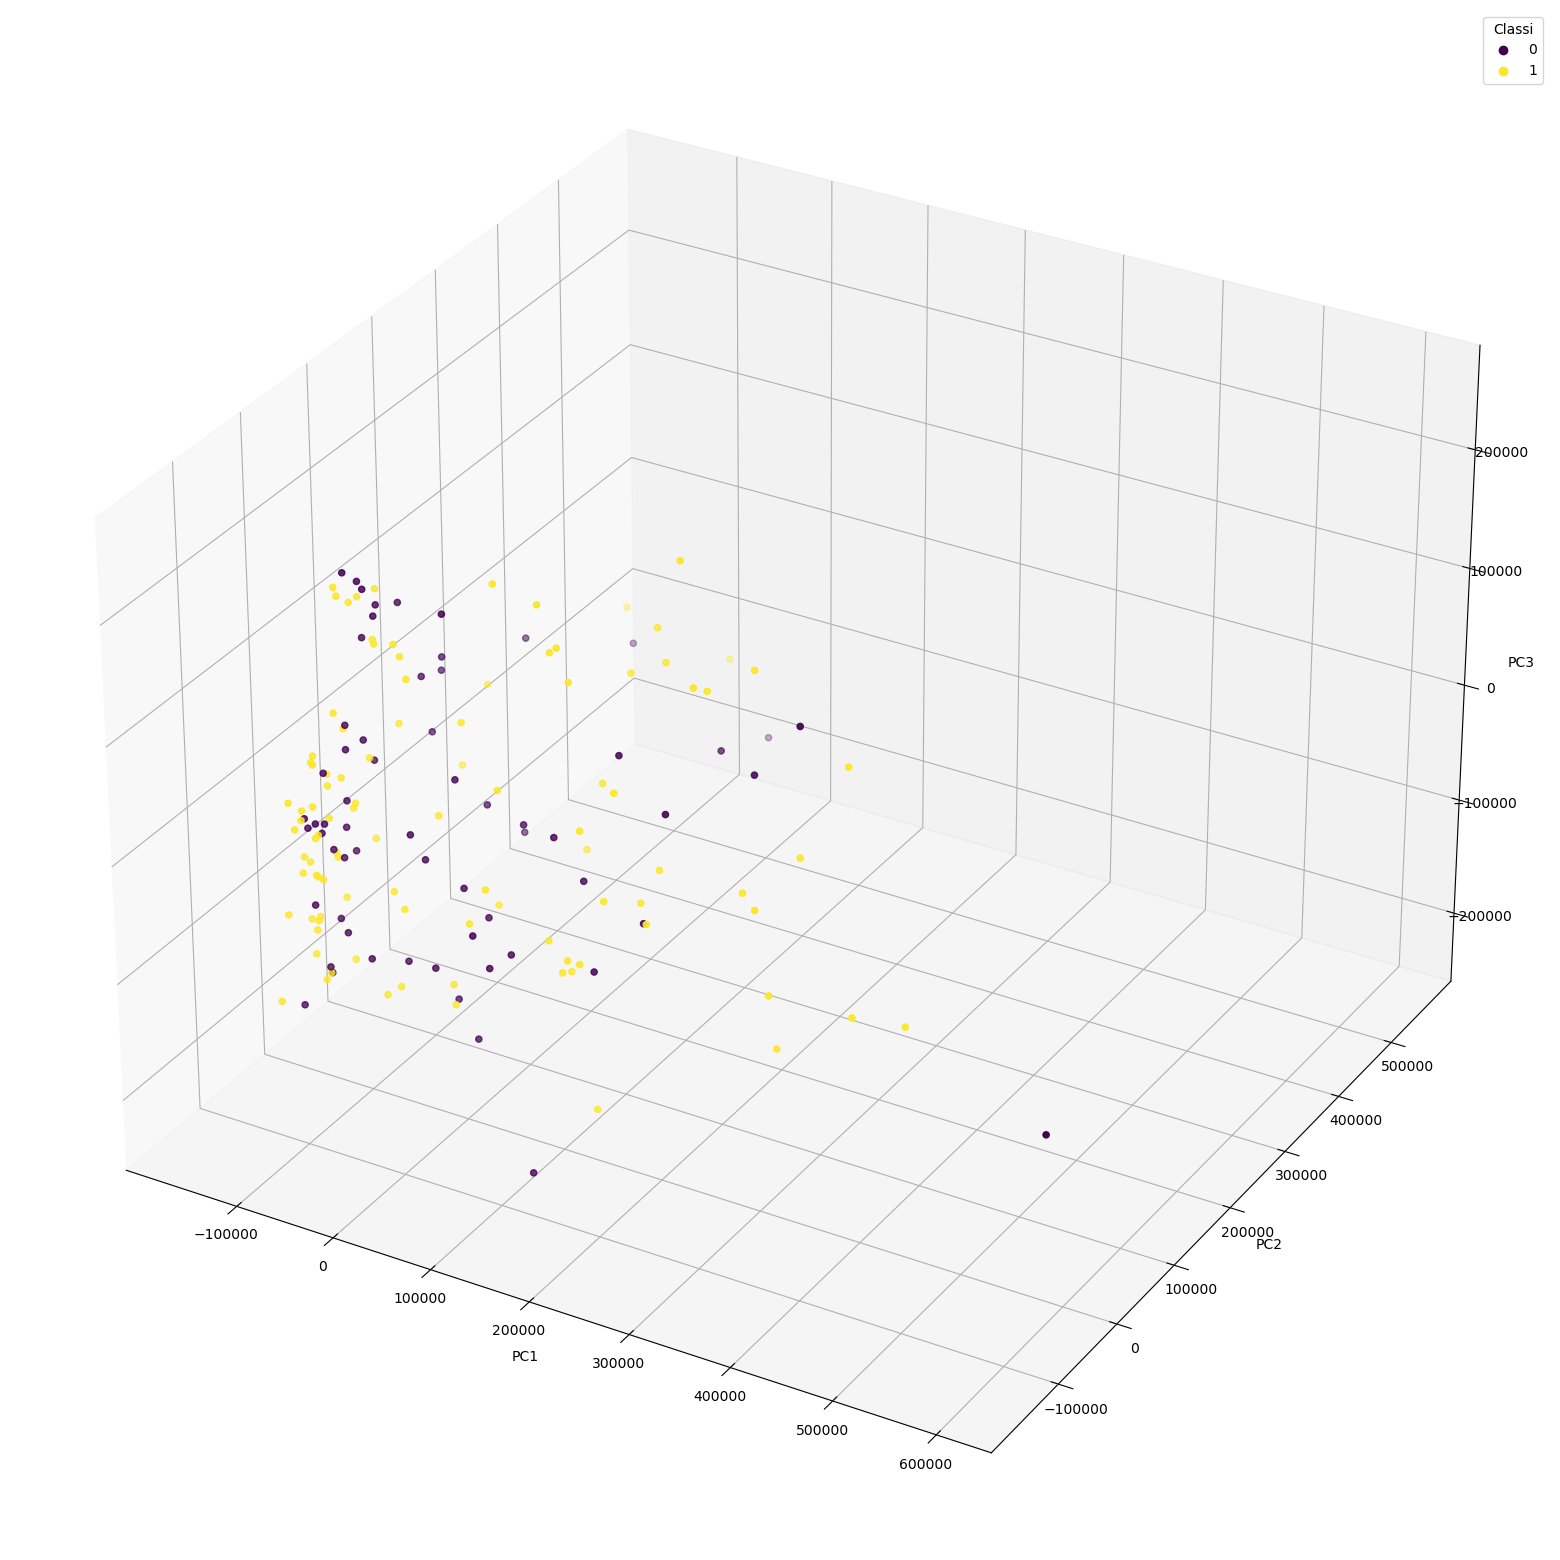

In [ ]:
# Creazione di un grafico 3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plotting dei punti nel grafico 3D
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Aggiungiamo una legenda per i colori
legend = ax.legend(*scatter.legend_elements(), title='Classi')

# Mostriamo il grafico
plt.show()

Con la PCA l'accuratezza del modello si riduce drasticamente, inoltre plottare le tre componenti principali non ci da nessuna informazione rilevante.

### 9. Results

Visualizziamo i risultati migliori.

In [ ]:
# Numero ottimale di fold 
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

# Modello eXtreme Gradient Boost con gli iperparametri ottimizzati
model = xgb.XGBClassifier(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
scores = cross_val_score(model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.81875
